In [192]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
import neurokit2 as nk
from scipy.optimize import least_squares
from scipy.signal import spectrogram
import copy
import pywt
from pathlib import Path
from IPython.display import clear_output

In [193]:
def readCsv(pathFile):
    arrays = []

    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        for line in lines:
            line_values = line.strip().split(',')
            arrays.append(line_values)
    complex_array = []
    for array in arrays:

        complex_value = np.array(
            [complex(element.replace('i', 'j')) for element in array])
        complex_array.append(complex_value)
    np.array(complex_array)
    return np.array(complex_array)

In [194]:
def read_est_file(pathFile):
    arrays = []
    with open(pathFile, 'r') as file:
        # Read the lines of the file
        lines = file.readlines()
        
        for value in lines:
            arrays.append(float(value.strip()))
    return arrays

In [195]:
T_c = 91.72 * (1e-6)   # Chirp time
SAMPLE_PER_CHIRP = 256
B =3.75 * (1e9) #bandwidth
# Calculate frequency variation
wavelength=3.947
speed_of_light = 300000000
NUMBER_OF_CHANNEL=4
FPS=20 #20 frame/s
CHIRP_PER_FRAME=2 # 2 chirp/ frame
DURATION=5#minute
FRAME_COUNT = DURATION * 60 * FPS
SAMPLE_PER_FRAME = CHIRP_PER_FRAME *SAMPLE_PER_CHIRP
FFT_SIZE=2**8
RANGE_RESOLUTION =float(speed_of_light)/(2*B)
SAMPLING_RATE = 3000e3;
FREQ_SLOPE =40.8450012207031251e6*1e6
RANGE_BIN =(float(speed_of_light) * SAMPLING_RATE) / (2*FREQ_SLOPE*FFT_SIZE) ;

MAX_RANGE =(SAMPLING_RATE *speed_of_light)/(2*FREQ_SLOPE);

print("Number of frame: {0}".format(FRAME_COUNT))
print("Number of sample per frame: {0}".format(SAMPLE_PER_FRAME))
print("FFT size {0}".format(FFT_SIZE))
print("Range resolution {0}".format(RANGE_RESOLUTION))
print("Range bin {0}".format(RANGE_BIN))
print("Max range {0}".format(MAX_RANGE))

Number of frame: 6000
Number of sample per frame: 512
FFT size 256
Range resolution 0.04
Range bin 0.04303617205204089
Max range 11.017260045322468


In [196]:
def readRefFile(pathFile):
    beat_file =open(pathFile)
    beats = [float(br)for br in beat_file.read().split(",")]
    return beats

In [318]:
PERSON_NUMBER=7
#read data
file_path = '../FMCW Radar/Rawdata/Rawdata_{0}.csv'.format(PERSON_NUMBER)
raw_data = readCsv(file_path)

breath_est_paper=read_est_file("../FMCW Radar/Heart Rate & Breathing Rate/Breath_{0}.csv".format(PERSON_NUMBER))
heart_est_paper=read_est_file("../FMCW Radar/Heart Rate & Breathing Rate/Heart_{0}.csv".format(PERSON_NUMBER))
breaths=readRefFile("../Nihon Kohden/Heart Rate & Breathing Rate/Ref_Breath_{0}.csv".format(PERSON_NUMBER))
heart=readRefFile("../Nihon Kohden/Heart Rate & Breathing Rate/Ref_Heart_{0}.csv".format(PERSON_NUMBER))

In [319]:
data_channel=raw_data[0]
print(data_channel.shape)
print(FRAME_COUNT*2*SAMPLE_PER_CHIRP)
single_chirp_data =np.array([data_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)])
double_chirp_data =np.array([data_channel[SAMPLE_PER_FRAME*i:SAMPLE_PER_FRAME*(i+1)]for i in range(0,FRAME_COUNT)])
print(single_chirp_data.shape)
print(double_chirp_data.shape)


(3072000,)
3072000
(6000, 256)
(6000, 512)


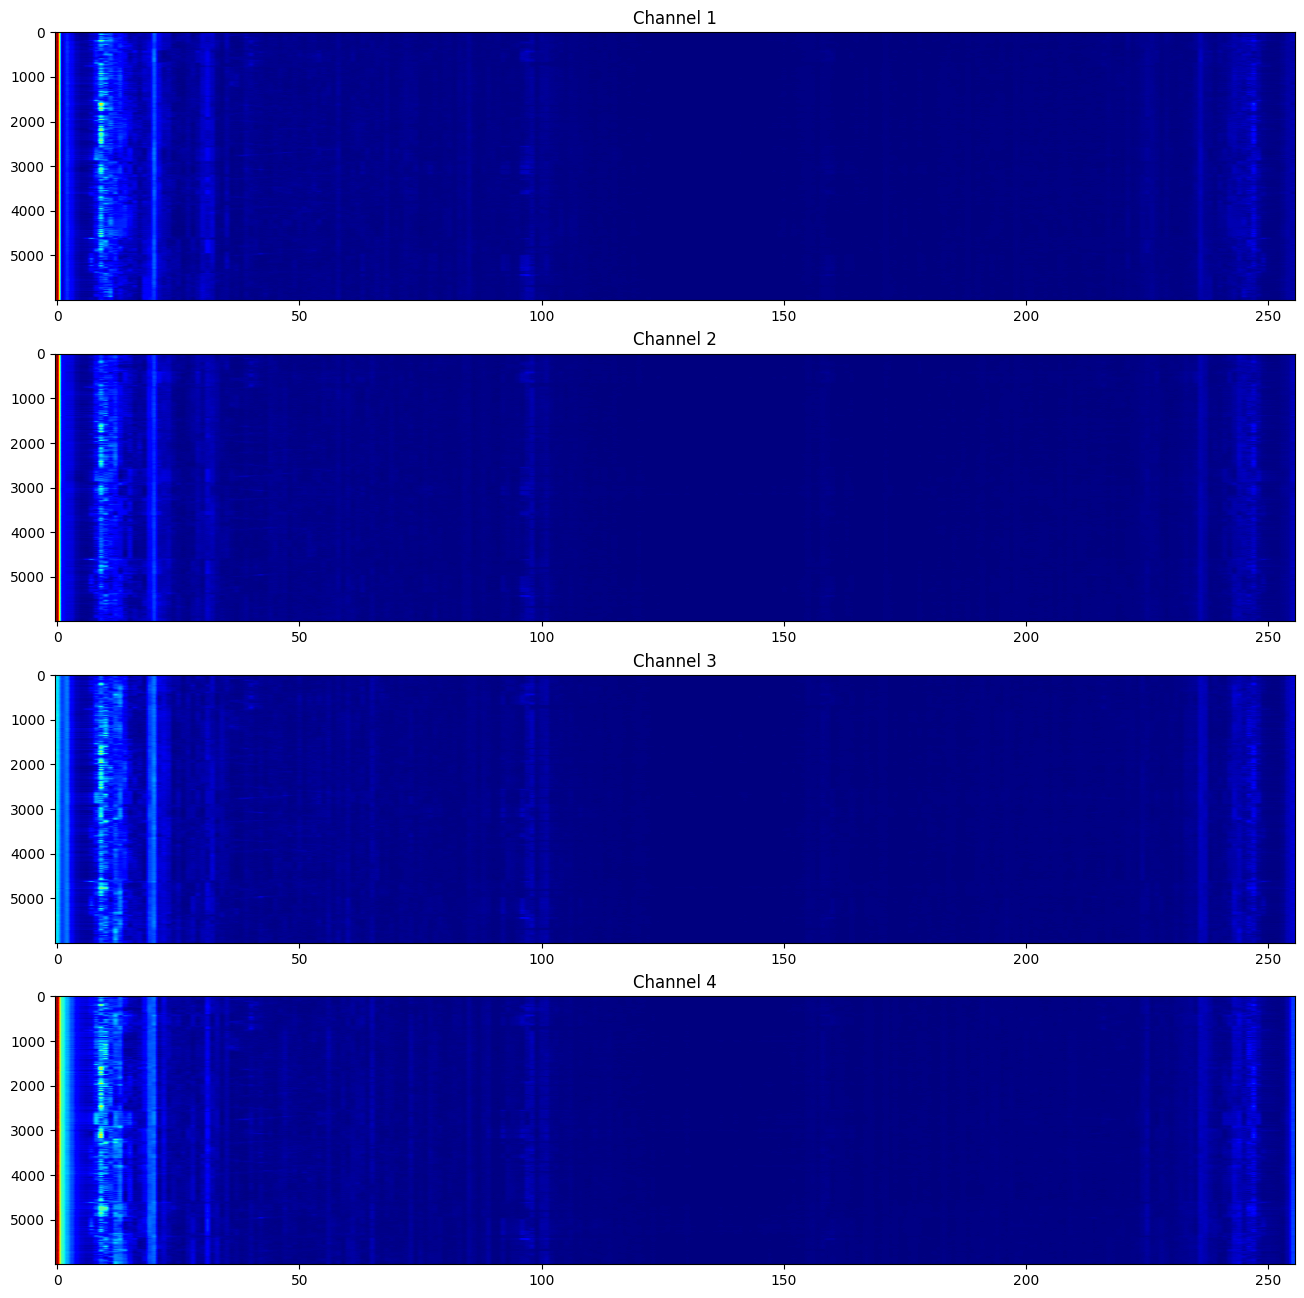

In [320]:
eveluate_channel =[]
for ii in range(0,4):
    tmp_channel=raw_data[ii]
    eveluate_channel.append(np.array([tmp_channel[2*i*SAMPLE_PER_CHIRP:SAMPLE_PER_CHIRP*(2*i+1)]for i in range(0,FRAME_COUNT)]))

plt.figure(figsize=(16,16))
for ii in range(0,4):
    plt.subplot(4,1,ii+1)
    plt.imshow(np.abs(np.fft.fft(eveluate_channel[ii])),cmap='jet',aspect='auto')
    plt.title("Channel {0}".format(ii+1))
plt.show()

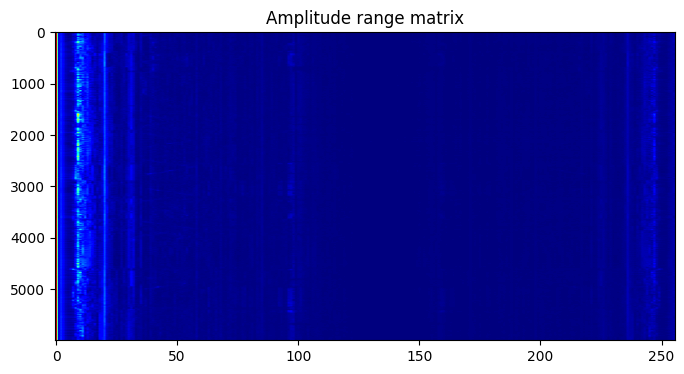

In [321]:
#calculate the amplitude range-matrix
est_channel=single_chirp_data
fft_output =np.fft.fft(est_channel,axis=1)
amplitude_range_matrix=np.abs(fft_output)
plt.figure(figsize=(8,4))
plt.imshow(amplitude_range_matrix,cmap='jet',aspect='auto')
plt.title("Amplitude range matrix")
plt.show()

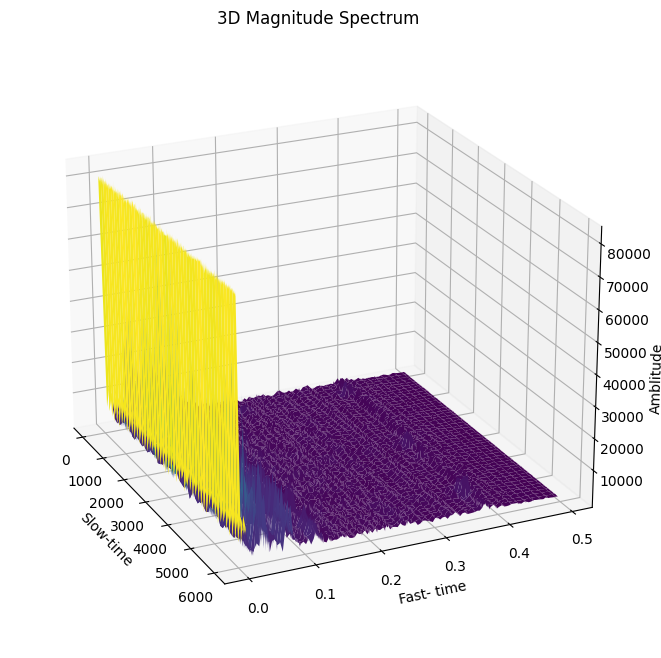

In [322]:
def genetate3DAmplitudeRangeMap(amplitudeRangeMap):
    
    num_range_profile =amplitudeRangeMap.shape[0]
    range_profile_len =amplitudeRangeMap.shape[1]

    frequencies = np.fft.fftfreq(range_profile_len)

    # Create grid for 3D plotting
    x = np.arange(num_range_profile)
    y = frequencies[:range_profile_len//2]
    x, y = np.meshgrid(x, y)

    # Magnitude of the FFT components for the first half of the frequencies
    fft_magnitude = amplitudeRangeMap[:, :range_profile_len//2]
    
    # Plotting
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    # Plot the 3D surface
    ax.plot_surface(x, y, fft_magnitude.T, cmap='viridis')

    ax.set_title('3D Magnitude Spectrum')
    ax.set_xlabel('Slow-time')
    ax.set_ylabel('Fast- time')
    ax.set_zlabel('Amblitude')
    ax.view_init(elev=22.5, azim=-25)  # Change the angles as desired
    plt.show()
genetate3DAmplitudeRangeMap(amplitude_range_matrix)

(6000, 256)


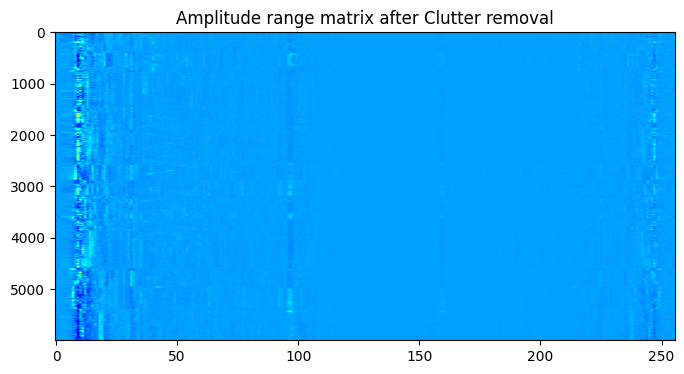

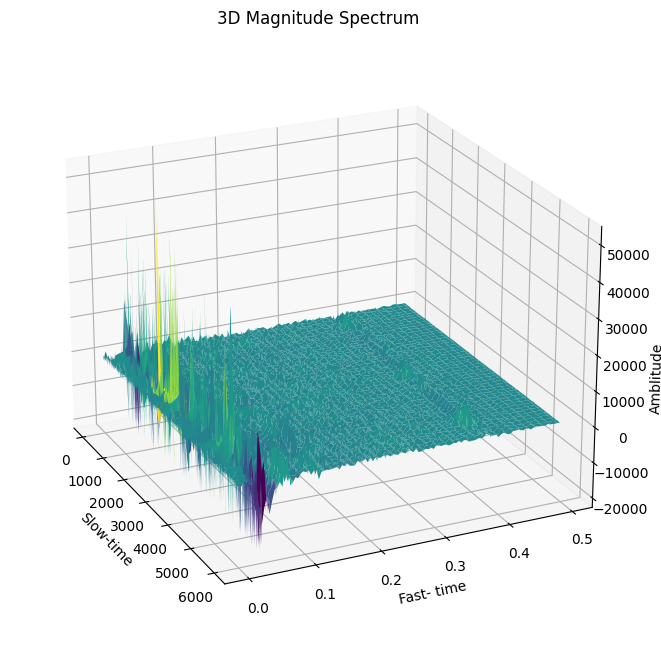

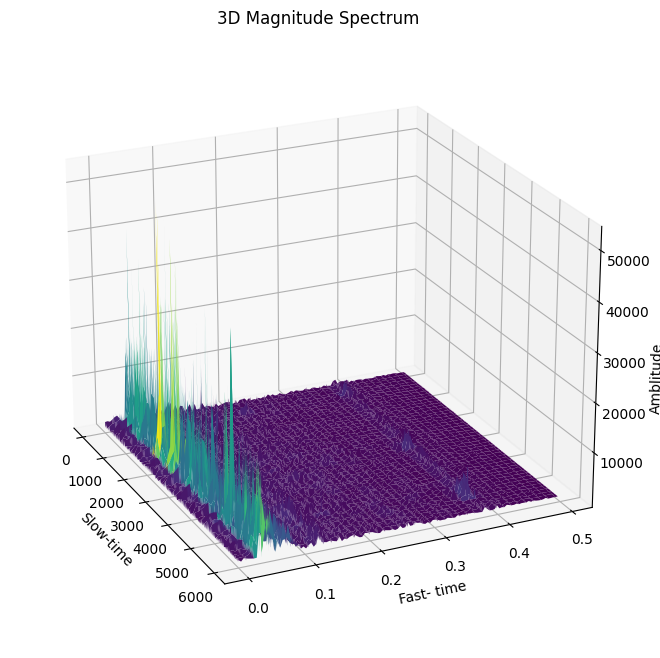

In [323]:
#clutter removal
(m,n)=amplitude_range_matrix.shape
amplitude_range_matrix_hat =np.zeros_like(amplitude_range_matrix)
print((m,n))
for column in range(0,n):
    # meanValueOfBin = np.average(amplitude_range_matrix[:,column])
    meanValueOfBin = np.sum(amplitude_range_matrix[:,column])/len(amplitude_range_matrix[:,column])
    meanValueOfBinArray=np.array([meanValueOfBin]*m)
    amplitude_range_matrix_hat[:,column] = amplitude_range_matrix[:,column] - meanValueOfBinArray

plt.figure(figsize=(8,4))
plt.imshow((amplitude_range_matrix_hat),cmap='jet',aspect='auto')
plt.title("Amplitude range matrix after Clutter removal")
plt.show()
amplitude_range_matrix_hat_abs=np.abs(amplitude_range_matrix_hat)
genetate3DAmplitudeRangeMap(amplitude_range_matrix_hat)
genetate3DAmplitudeRangeMap(amplitude_range_matrix_hat_abs)




[3164564.058954648, 3874714.963895782, 4303121.43439989, 5002917.148390273, 5675427.068816695, 6150989.385185806, 7394567.879913329, 14582565.599211156, 25535889.957670674, 61267820.75926456, 38697456.341630295, 28590938.847751632, 21057462.62798539, 19817474.108374782, 17598051.42506603, 13437553.12147435, 10208884.949098445, 7772288.6112717055, 10380506.977432527, 9292905.998403281, 8389721.9083445, 8378051.747997223, 6438936.748121383, 5639438.639965869, 4840585.164431306, 4814421.5004082825, 3620481.078798279, 4052807.4057414574, 4711063.407600779, 5051772.260430882, 5109639.837840162, 10463255.066106282, 5898101.934928747, 3566780.7678109095, 2638599.904635083, 5269016.616283461, 3449317.20594416, 3423350.0744854594, 2814292.6151747974, 3781190.376812318, 4509786.781674089, 3734911.2689174158, 3387373.3014009735, 2926171.0024465024, 2783320.352626883, 2819096.7792214155, 2694359.338409858, 2910591.1387892594, 2767546.48750142, 2923660.582069015, 2917934.976566703, 2664181.11495655

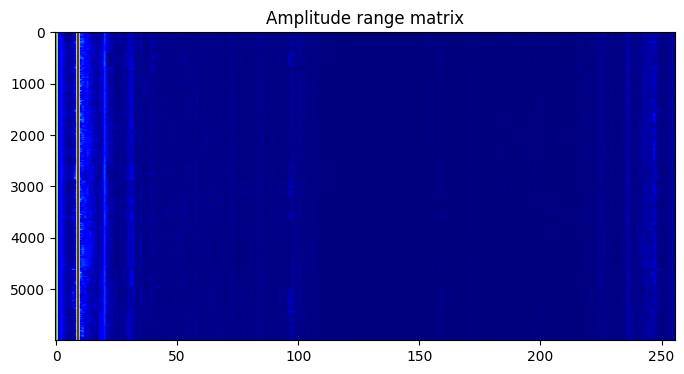

In [324]:
#calculate target location
(m,n)=amplitude_range_matrix_hat_abs.shape
nBins=[]
for column in range(0,n):
    binNTh=(np.sum(amplitude_range_matrix_hat_abs[:,column]))
    nBins.append(binNTh)
    
print(nBins)
nThBinTarget= np.argmax(nBins)
print("Target at bin  {0} with the sumation value {1}".format(nThBinTarget,nBins[nThBinTarget]))

tmp_amplitude_range_matrix=np.abs(fft_output)
tmp_amplitude_range_matrix[:,nThBinTarget]=99999
plt.figure(figsize=(8,4))
plt.imshow(tmp_amplitude_range_matrix,cmap='jet',aspect='auto')
plt.title("Amplitude range matrix")
plt.show()
interesting_bin =nThBinTarget


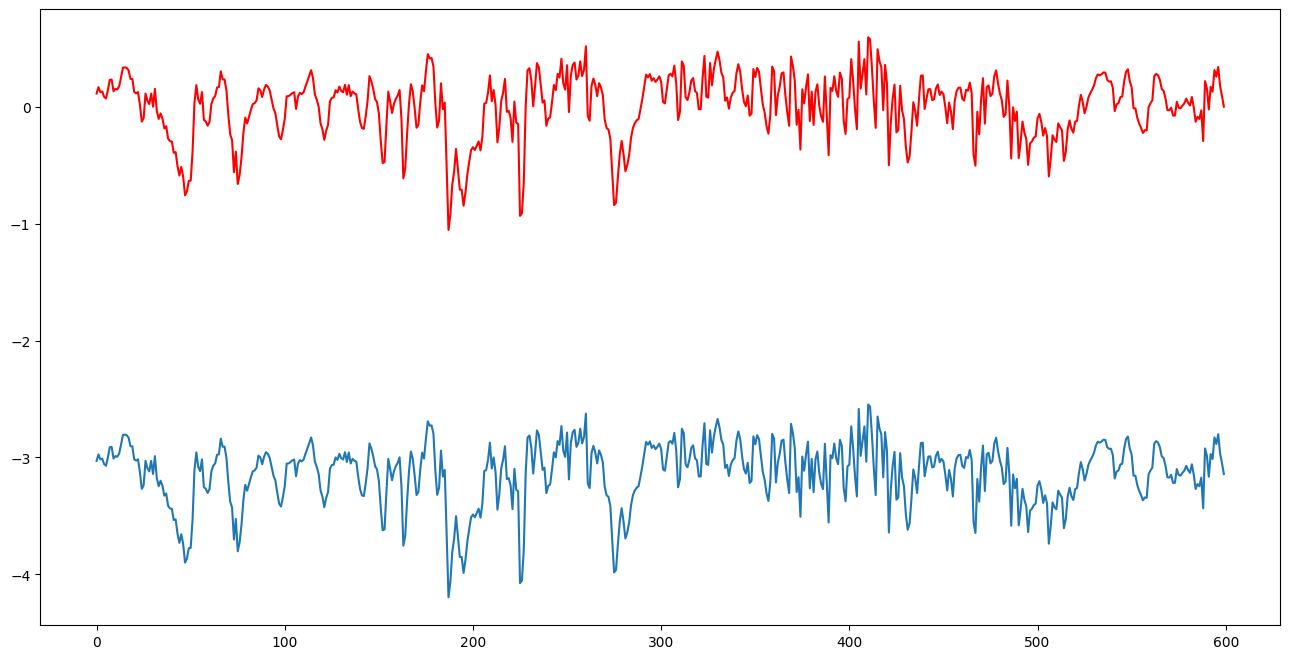

In [325]:
#calculate phase
realParts = np.real(est_channel[:,interesting_bin])
imagParts = np.imag(est_channel[:,interesting_bin])
phaseArctan = np.unwrap(np.arctan(imagParts/realParts))
phaseAngle=np.unwrap(np.angle(est_channel[:,interesting_bin]))

plt.figure(figsize=(16,8))
# plt.plot(np.fft.fft(phaseArctan[0:100]),color="red")
# plt.plot(np.fft.fft(phaseAngle[0:100]))
plt.plot(phaseArctan[0:600],color="red")
plt.plot(phaseAngle[0:600])
plt.show()

In [326]:
def filter_signal (signal_to_filter ,_low_freq,_high_freq,_sampling_rate,_filter_order):
    sampling_rate = _sampling_rate# Sampling rate of the input signal
    low_freq = _low_freq  # Lower cutoff frequency of the bandpass filter
    high_freq = _high_freq  # Upper cutoff frequency of the bandpass filter
    filter_order = _filter_order # Order of the bandpass filter

    # Compute the normalized cutoff frequencies
    nyquist_freq = 0.5 * sampling_rate
    low_norm = low_freq / nyquist_freq
    high_norm = high_freq / nyquist_freq
    
    # Design the bandpass filter
    b, a = butter(filter_order, [low_norm, high_norm], btype='band')

    # Apply the bandpass filter to the input signal
    signal_filtered = filtfilt(b, a, signal_to_filter)
    return signal_filtered

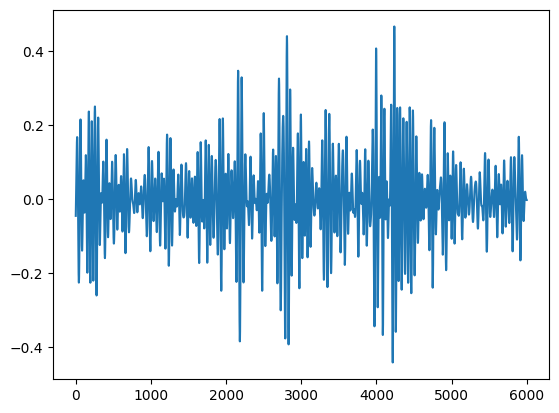

In [430]:
#filter to get breath component signal
filtered_breath_phase_arctan=filter_signal(phaseArctan,0.3,0.6,20,5)

plt.plot(filtered_breath_phase_arctan)
plt.show()
plt.show()

In [431]:
def estSignal(input_signal,sampling_rate,min_freq,max_freq):
    scales = np.arange(1, 32)  # Scales for wavelet transform
    wavelet = 'cmor'  # Complex Morlet wavelet
    # Perform Continuous Wavelet Transform (CWT)
    coefficients, frequencies = pywt.cwt(input_signal, scales, wavelet, sampling_period=1/sampling_rate)
    conditions =(np.where((frequencies >= min_freq) & (frequencies <= max_freq)))
    
    for c in conditions[0]:
        print(c,"  -   ",60* frequencies[c])
    # print(conditions)
    # indices = (conditions[0][0]+conditions[0][-1])//2
    indices = conditions[0][1]
    filtered_coeff =coefficients[indices]
    print(indices," <-----> ",60*frequencies[indices])

    return filtered_coeff

In [432]:
signal_est_with_wavelet_transform =estSignal(filtered_breath_phase_arctan,20,0.3,0.6)


16   -    35.29411764705882
17   -    33.33333333333333
18   -    31.57894736842105
19   -    30.0
20   -    28.57142857142857
21   -    27.272727272727273
22   -    26.08695652173913
23   -    24.999999999999996
24   -    23.999999999999996
25   -    23.076923076923077
26   -    22.22222222222222
27   -    21.428571428571427
28   -    20.68965517241379
29   -    20.0
30   -    19.35483870967742
17  <----->  33.33333333333333


In [433]:
def MAPE(refSignal,actualSignal):
    arrayRef=np.array(refSignal)
    arrayAct=np.array(actualSignal)
    error =1/len(refSignal)*np.sum(np.abs((arrayAct-arrayRef)/arrayAct))
    print(error)
    return error
    

In [434]:

def getWindowFreq(signal_window,rate_of_sampling):
    fft_result = np.fft.fft(signal_window)
    freqs = np.fft.fftfreq(len(signal_window), 1 / rate_of_sampling)
    dominant_frequency = np.abs(freqs[np.argmax(np.abs(fft_result))])
    return round(dominant_frequency * 60,1)

def estFreq(signal_for_est):
    initDuration=20
    sampling_rate=20
    window_size= initDuration*sampling_rate
    
    freq_peaks=[0]*(initDuration-1)
    overlap=20
    start_idx = 0
    while start_idx + window_size <= len(signal_for_est):
        end_idx = start_idx + window_size
        window_signal = signal_for_est[start_idx:end_idx]
        windowFreq=getWindowFreq(window_signal,sampling_rate)
        freq_peaks.append(windowFreq)
        start_idx += overlap
    print(freq_peaks)
    return freq_peaks

fixed_bin_freq_breath=estFreq(signal_est_with_wavelet_transform)

print(breaths)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 21.0, 21.0, 21.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 24.0, 24.0, 24.0, 24.0, 24.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 27.0, 27.0, 27.0, 27.0, 27.0, 30.0, 30.0, 30.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 24.0, 24.0, 24.0, 24.0, 24.0, 33.0, 33.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 24.0, 24.0, 24.0, 24.0, 24.0, 27.0, 27.0, 27.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 27.0, 

0.12028363997113996
0.10254043099889638


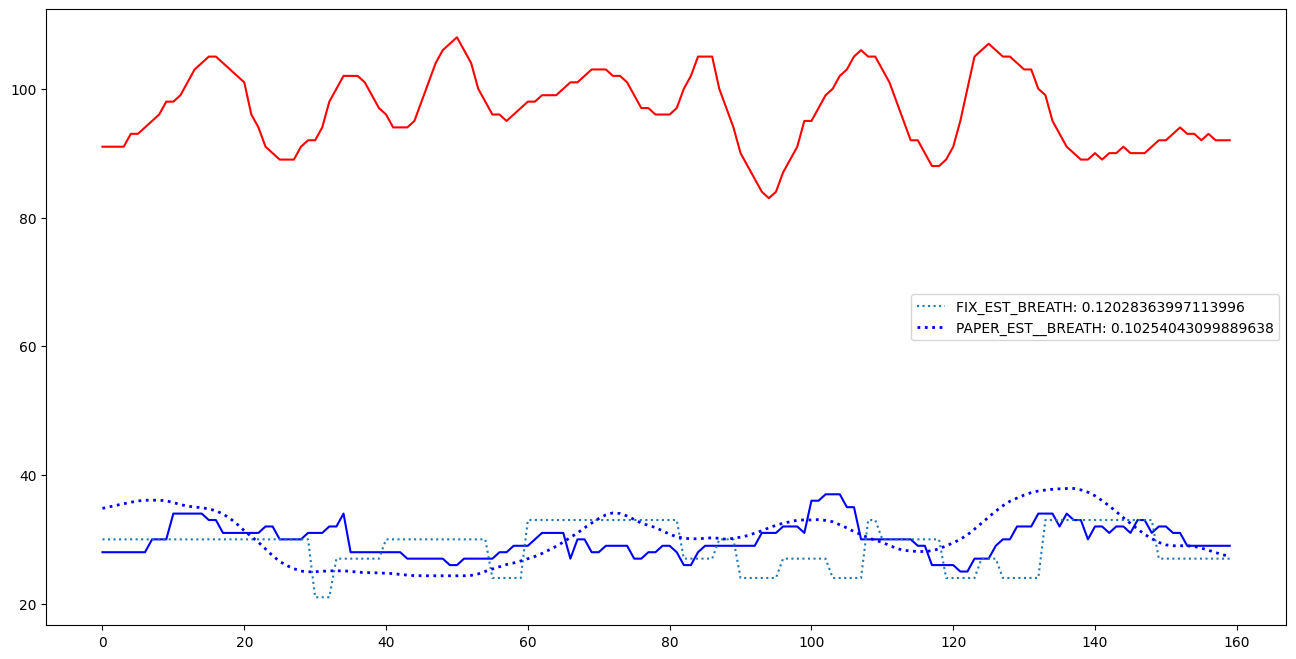

In [435]:
START_SIGNAL=20
END_SIGNAL=180
mape_br=MAPE(breaths[START_SIGNAL:END_SIGNAL],fixed_bin_freq_breath[START_SIGNAL:END_SIGNAL])
mape_br_paper=MAPE(breaths[START_SIGNAL:END_SIGNAL],breath_est_paper[START_SIGNAL:END_SIGNAL])
plt.figure(figsize=(16,8))
plt.plot(breaths[START_SIGNAL:END_SIGNAL],color="blue",linestyle='solid')
plt.plot(heart[START_SIGNAL:END_SIGNAL],color="red",linestyle='solid')
plt.plot(fixed_bin_freq_breath[START_SIGNAL:END_SIGNAL],label="FIX_EST_BREATH: {0}".format(mape_br),linestyle='dotted')
plt.plot(breath_est_paper[START_SIGNAL:END_SIGNAL],label="PAPER_EST__BREATH: {0}".format(mape_br_paper),color="blue",linestyle='dotted',linewidth=2)
plt.legend()
plt.show()